# RankByDarkAndSLI

Post process machine learning predictions by dark kinase and SLI information.

In [1]:
import os
import sys
import pandas as pd
import numpy as np
sys.path.insert(0, os.path.abspath('..'))
from kcet import KcetParser

## Predictions derived from PubMed embeddings
We have generated predictions that relate protein kinases to cancers in notebooks such as ``RandomForestPredictions``.

The purpose of the current notebook is to prioritize these predictions by using prediction 
synthetic lethality interactions (SLIs) and to filter them according to  their status as 
1. Tclin -- proteins targeted by approved drugs with known mechanism of action.
2. Tchem -- proteins targeted by small molecules/drugs in ChEMBL or DrugCentral 
3. Tbio -- proteins that do not have known above-threshold drug or small molecule activities and are above the cutoff for Tdark and are annotated with a Gene Ontology Molecular Function or Biological Process leaf term(s) with an Experimental Evidence code
4. Tdark -- proteins about which virtually nothing is known. 

## Random forest predictions
From the ``RandomForestPredictions`` notebook.

In [2]:
predictions = pd.read_csv("predictions_2021.tsv",sep="\t")

In [3]:
predictions.head()

,gene_symbol,cancer,probability
0,EGFR,"Mixed Tumor, Malignant",0.94
1,JAK2,"Carcinoma, Hepatocellular",0.90
2,KDR,"Mixed Tumor, Malignant",0.90
3,IGF1R,"Carcinoma, Hepatocellular",0.90
4,PTK2,"Carcinoma, Hepatocellular",0.84


## TDL categories
We retrieve a dataframe to display the data (``tld_df``). We then retrieve a map from the same data that related the gene symbol to the target level.

In [4]:
kcet_parser = KcetParser()
tld_df = kcet_parser.read_target_level_df()

In [5]:
tld_df.head()

,Sym,UniProt,Description,GeneID,TDL
0,AAK1,Q2M2I8,AP2-associated protein kinase 1,22848.0,Tchem
1,AATK,Q6ZMQ8,Serine/threonine-protein kinase LMTK1,9625.0,Tbio
2,ABL1,P00519,Tyrosine-protein kinase ABL1,25.0,Tclin
3,ABL2,P42684,Tyrosine-protein kinase ABL2,27.0,Tchem
4,ACVR1,Q04771,Activin receptor type-1,90.0,Tchem


In [6]:
symbol_to_tld_map = kcet_parser.get_symbol_to_tdl_map()

### Probability distribution of Tclin, Tchem, Tbio, and Tdark predictions
Here we plot the distributions of proteins in the four different TLD groups. Note that one protein will have multiple entries , one for each cancer.

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [10]:
tclin_pred =[]
tbio_pred = []
tchem_pred = []
tdark_pred = []
identified_kinases = set()
for _, row in predictions.iterrows():
    sym = row['gene_symbol']
    pr = float(row['probability'])
    tld = symbol_to_tld_map.get(sym, 'na')
    if tld == 'na':
        continue # Note -- our predictions contain more than kinases, 
        # We do not expect to find every symbol in this map
    else:
        identified_kinases.add(sym)
    if tld == 'Tchem':
        tchem_pred.append(pr)
    elif tld == 'Tbio':
        tbio_pred.append(pr)
    elif tld == 'Tclin':
        tclin_pred.append(pr)
    elif tld == 'Tdark':
        tdark_pred.append(pr)
    else:
        raise ValueError("Unrecognized category:", tld)
print("[INFO] Found values for %d kinases" % len(identified_kinases))

[INFO] Found values for 470 kinases


In [15]:
data1 = np.array(tclin_pred)
data2 = np.array(tchem_pred)
data3 = np.array(tbio_pred)
data4 = np.array(tdark_pred)

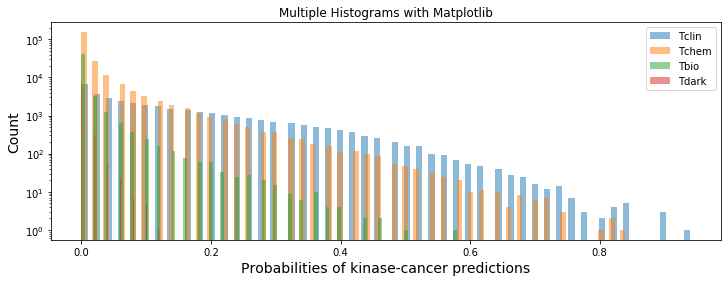

In [20]:
plt.figure(figsize=(12,4))
plt.hist(data1, bins=100, alpha=0.5, label="Tclin", log=True)
plt.hist(data2, bins=100, alpha=0.5, label="Tchem", log=True)
plt.hist(data3, bins=100, alpha=0.5, label="Tbio", log=True)
plt.hist(data4, bins=100, alpha=0.5, label="Tdark", log=True)
plt.xlabel("Probabilities of kinase-cancer predictions", size=14)
plt.ylabel("Count", size=14)
plt.title("Probabilities according to target development level (TDL)")
plt.legend(loc='upper right')

We see that the probabilities in the Tclin class include the highest values. This is expected, because this group includes our positive
set. Also, the fact that there are low probabilities in the Tclin group is expected, because not every combination of
a protein kinase and cancer is relevant. However, the fact that there are different distributions in the four groups
is to be expected.
The probability distributions of the positive and negative sets were plotted in the ``RandomForestPredictions`` notebook.